## 230B lab2


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Part I: Essential Functions

In [2]:
from ece230b import *

# Functions are provided in appendix

## Part II: Perform Pulse Shaping

In [3]:
# Generate random QAM symbols
symbols, constellation = gen_rand_qam_symbols(200, 4)

# Define list of rolloff factors
beta_list = [0.0, 0.25, 0.5, 0.75, 1.0]

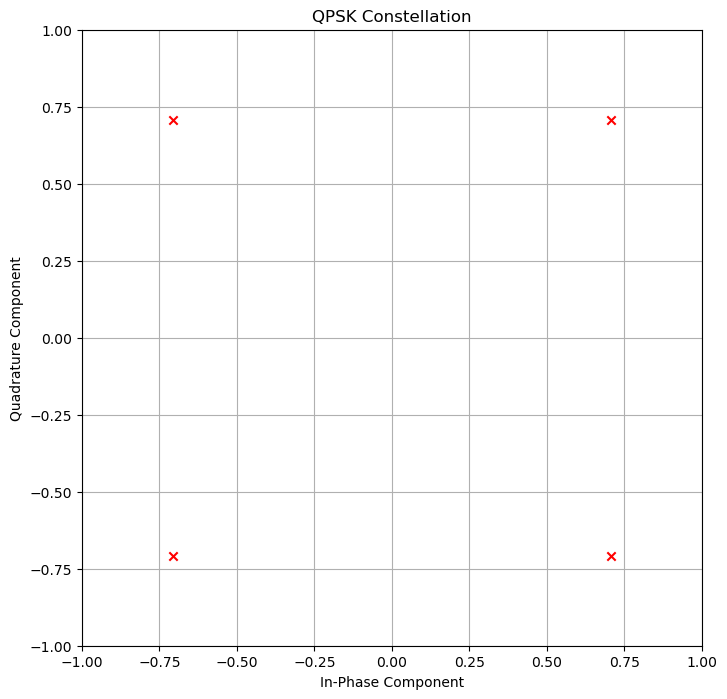

In [4]:
# A. Visualize the QPSK constellation

%matplotlib inline
plt.figure(figsize=(8, 8))
plt.scatter(constellation.real, constellation.imag, c='red', marker='x')
plt.title("QPSK Constellation")
plt.xlabel("In-Phase Component")
plt.ylabel("Quadrature Component")
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

c:\Users\bryan\Documents\school\ucla\UCLA 25S\ee 230b\ece230b.py:91: RuntimeWarning: divide by zero encountered in divide
  pulse = np.sinc(t) * ( np.cos(np.pi * beta * t) / (1 - ((2 * beta * t)**2)) )


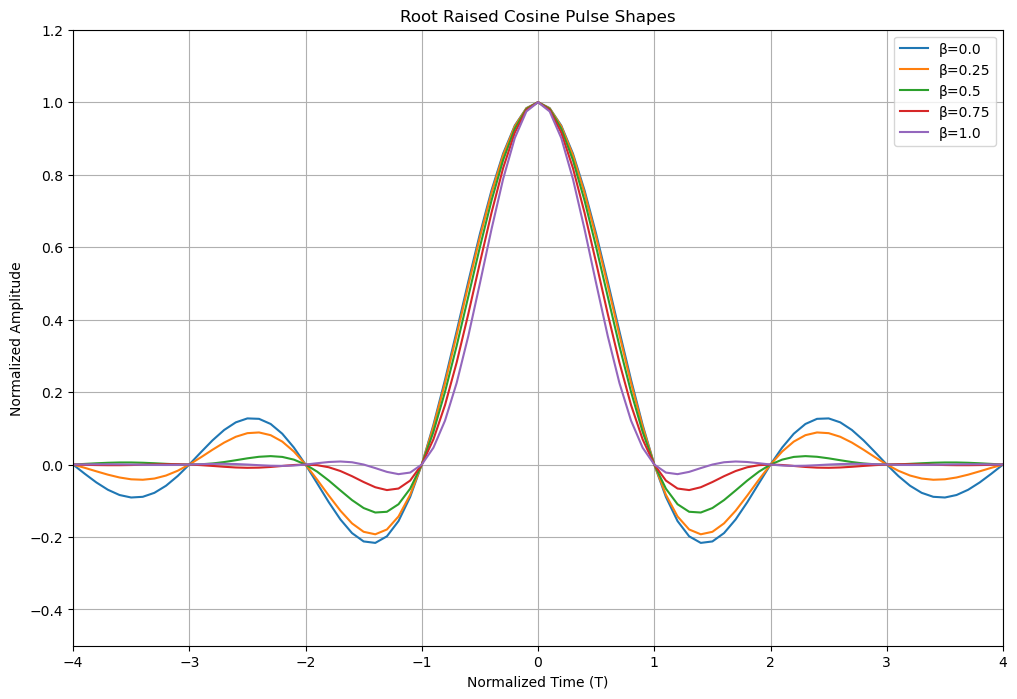

In [5]:
# B. Visualize the Pulse Shape for Various Rolloff Factors

span = 8 # Number of symbols to span
sps = 10 # Samples per symbol
pulse_arr = []

%matplotlib inline
plt.figure(figsize=(12, 8))
for beta in beta_list:
    t, pulse = get_rc_pulse(beta, span, sps)
    pulse_arr.append(pulse)
    plt.plot(t, pulse, label=f'β={beta}')
plt.title("Root Raised Cosine Pulse Shapes")
plt.xlabel("Normalized Time (T)")
plt.ylabel("Normalized Amplitude")
plt.xlim(-span/2, span/2)
plt.ylim(-0.5, 1.2)
plt.grid(True)
plt.legend()
plt.show()

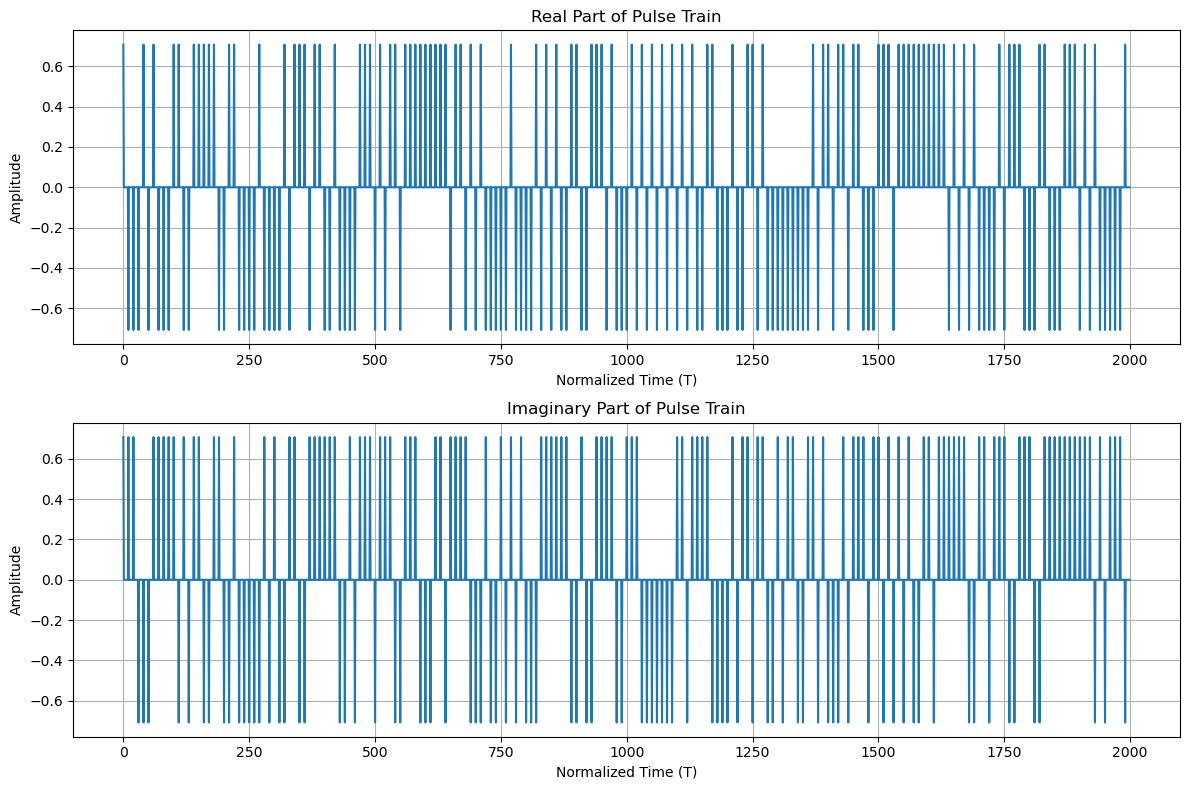

In [6]:
# C. Visualize the Pulse Train of Symbols

t, pulse_train = create_pulse_train(symbols, sps)

%matplotlib inline
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t, np.real(pulse_train))
plt.title("Real Part of Pulse Train")
plt.xlabel("Normalized Time (T)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(t, np.imag(pulse_train))
plt.title("Imaginary Part of Pulse Train")
plt.xlabel("Normalized Time (T)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

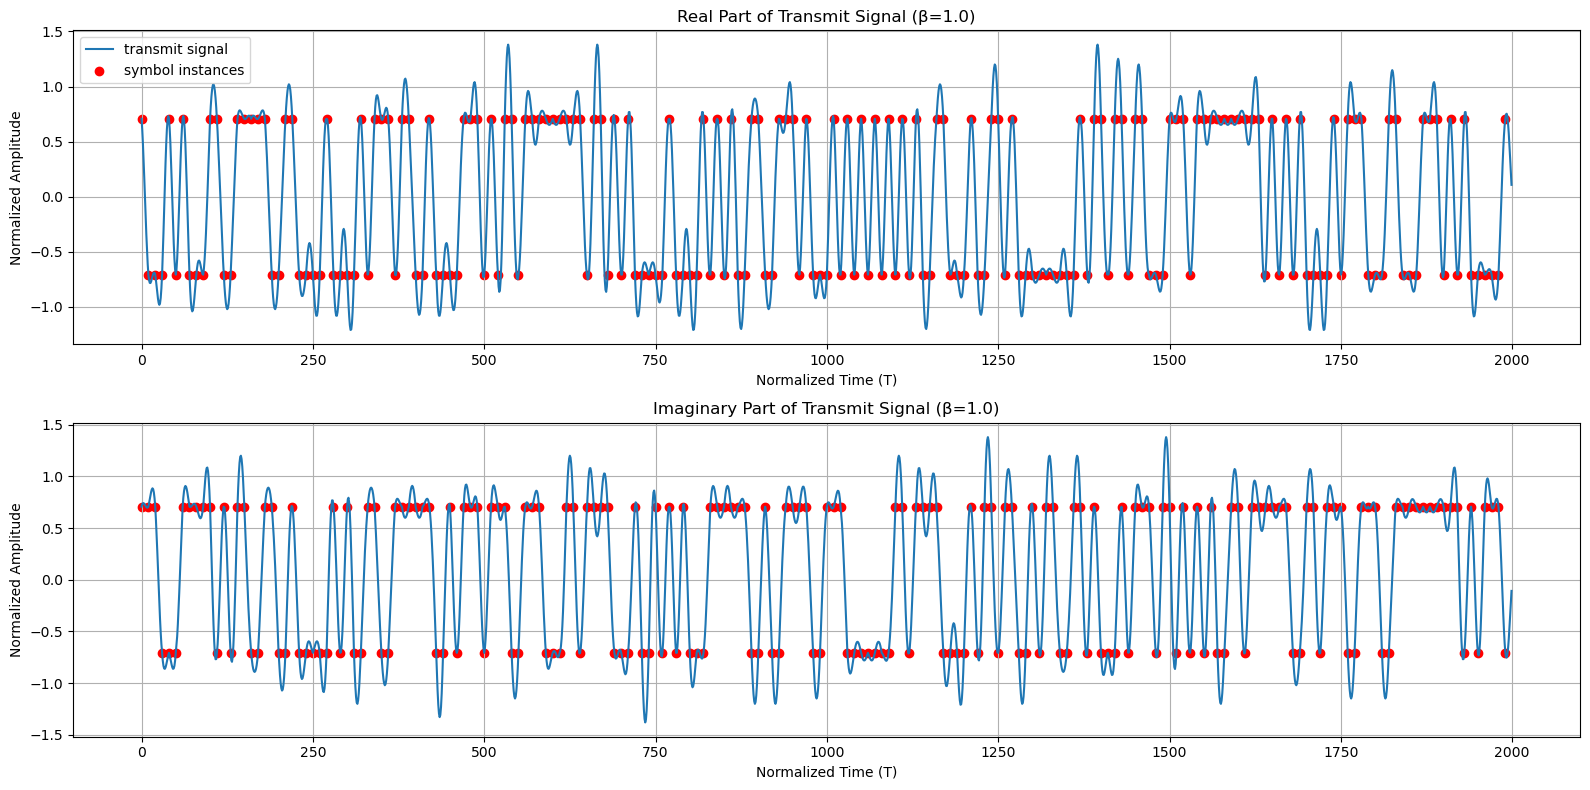

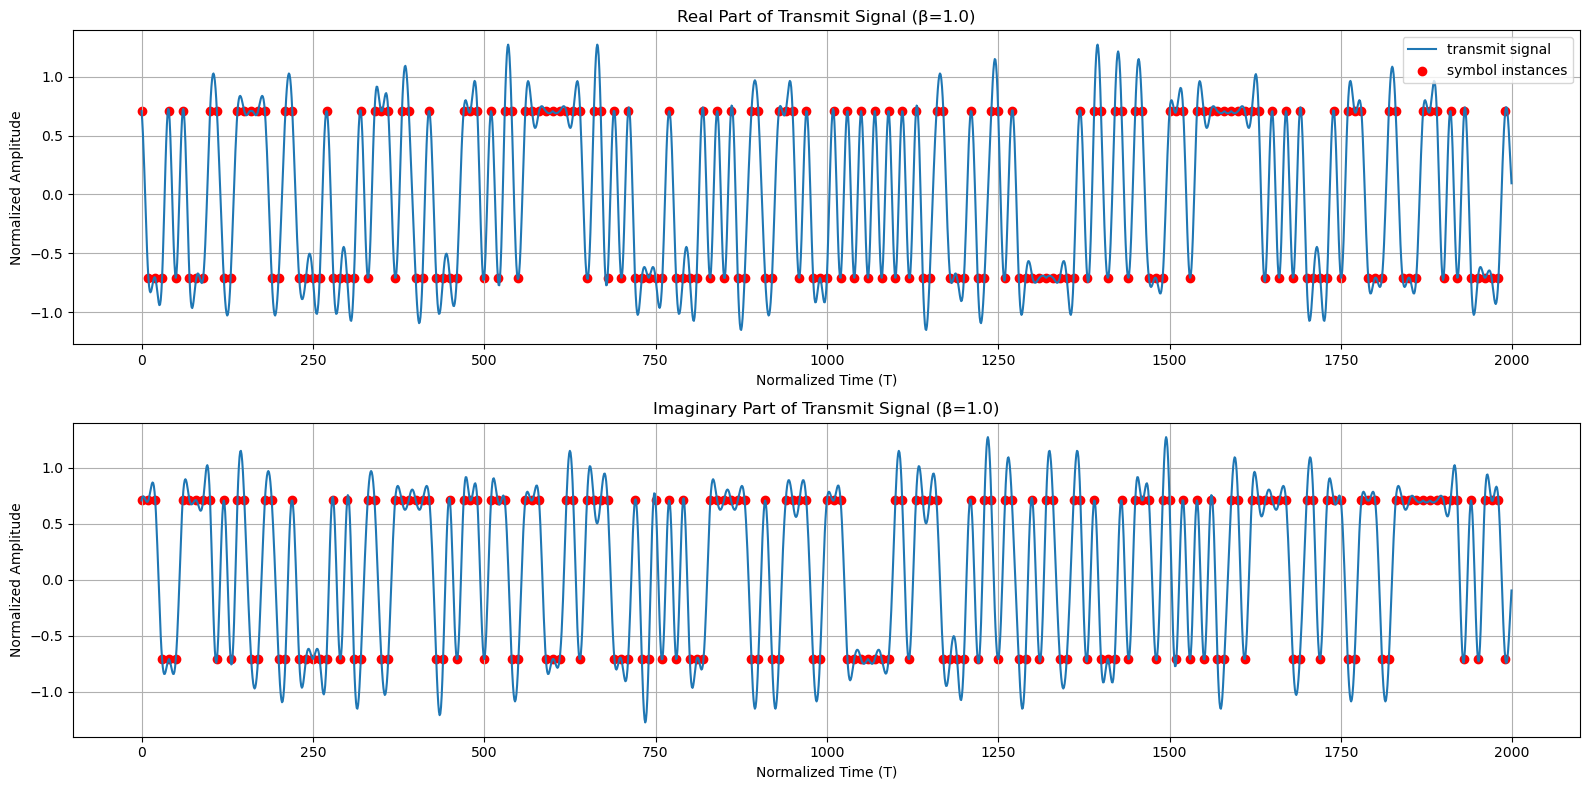

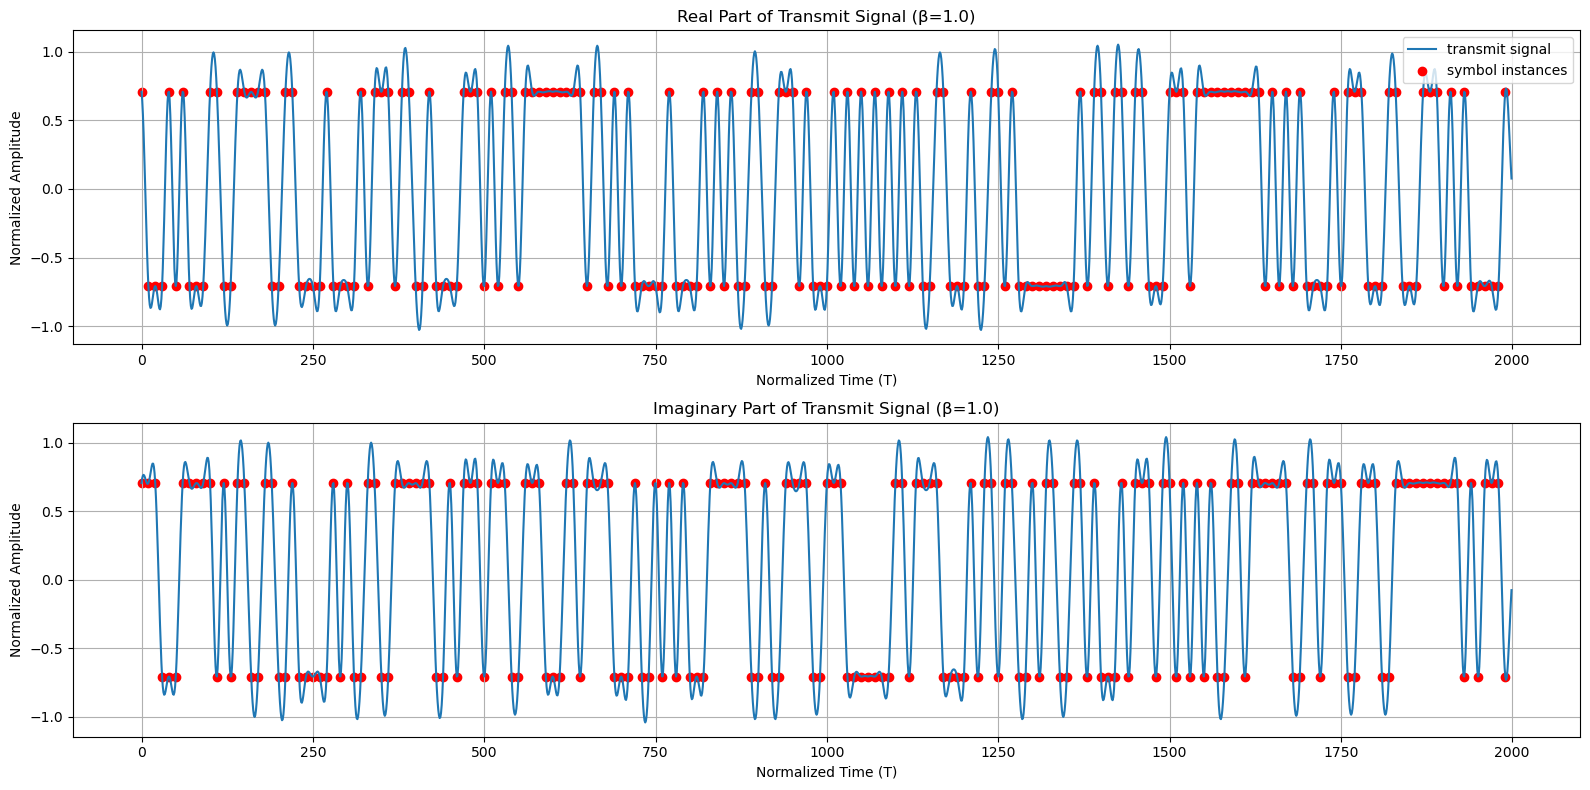

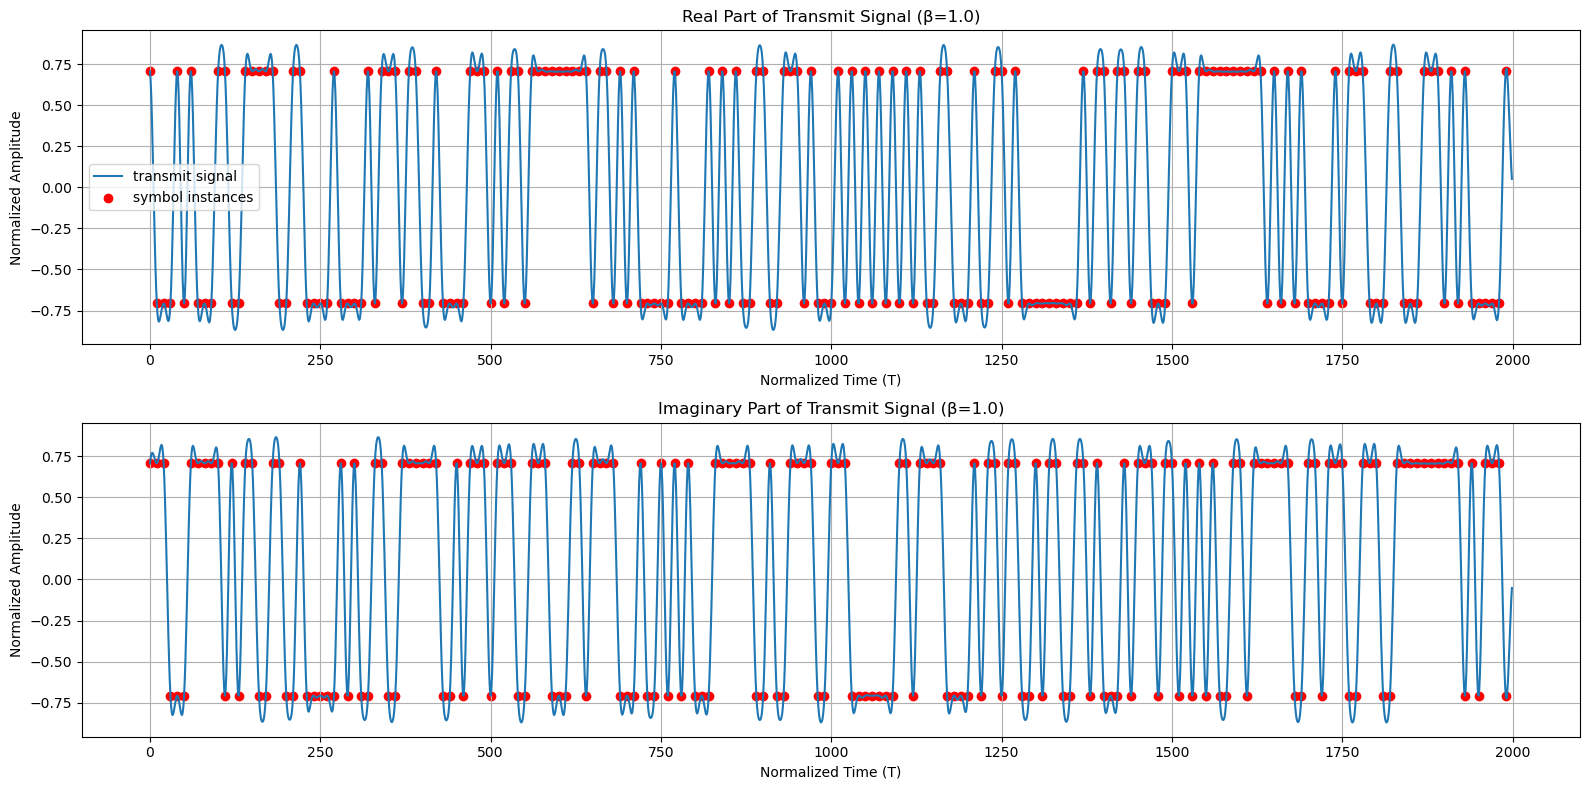

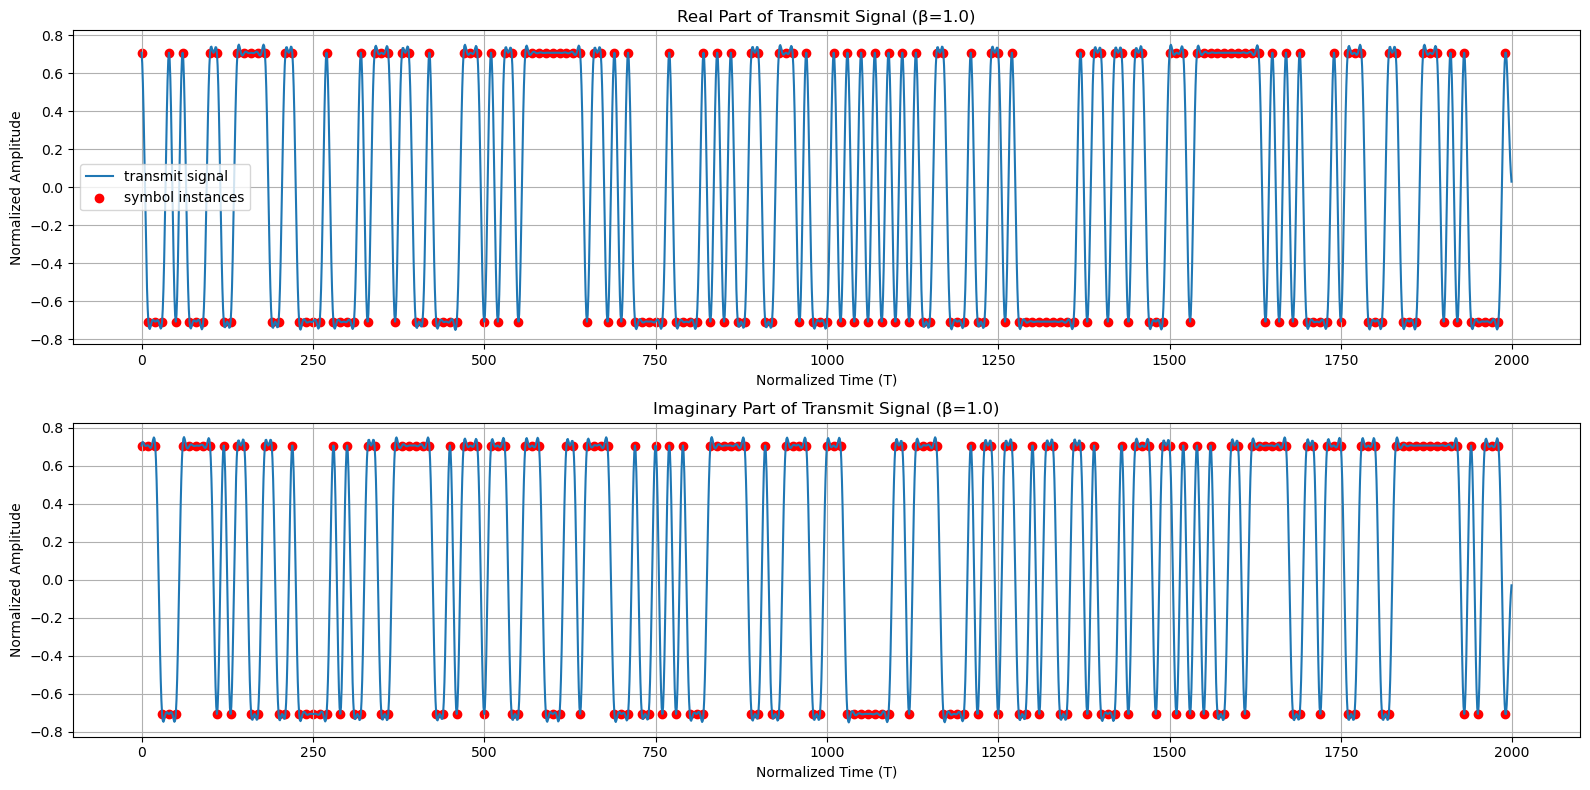

In [7]:
# D. Generate and Visualize the Pulse-Shaped Transmit Signal
t, pulse_train = create_pulse_train(symbols, sps)
tx_signal_arr = []

for idx in range(len(beta_list)): 
    tx_signal = np.convolve(pulse_arr[idx], pulse_train, mode='same')
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, np.real(tx_signal), label='transmit signal')
    plt.scatter(t[::sps], np.real(pulse_train[::sps]), color='red', marker='o', label='symbol instances')
    plt.title(f"Real Part of Transmit Signal (β={beta})")
    plt.xlabel("Normalized Time (T)")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True)
    plt.subplot(2, 1, 2)
    plt.plot(t, np.imag(tx_signal), label='transmit signal')
    plt.scatter(t[::sps], np.imag(pulse_train[::sps]), color='red', marker='o', label='symbol instances')
    plt.title(f"Imaginary Part of Transmit Signal (β={beta})")
    plt.xlabel("Normalized Time (T)")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    tx_signal_arr.append(tx_signal)

## Part III: Compare the FFT for Various Rolloff Factors

In [8]:
# Pluto SDR Setup
from remoteRF.drivers.adalm_pluto import *
# ---------------------------------------------------------------
# Digital communication system parameters.
# ---------------------------------------------------------------
fs = 1e6     # baseband sampling rate (samples per second)
ts = 1 / fs  # baseband sampling period (seconds per sample)
sps = 10     # samples per data symbol
T = ts * sps # time between data symbols (seconds per symbol)

# ---------------------------------------------------------------
# Pluto system parameters.
# ---------------------------------------------------------------
sample_rate = fs                # sampling rate, between ~600e3 and 61e6
tx_carrier_freq_Hz = 915e6      # transmit carrier frequency, between 325 MHz to 3.8 GHz
rx_carrier_freq_Hz = 915e6      # receive carrier frequency, between 325 MHz to 3.8 GHz
tx_rf_bw_Hz = sample_rate * 1   # transmitter's RF bandwidth, between 200 kHz and 56 MHz
rx_rf_bw_Hz = sample_rate * 1   # receiver's RF bandwidth, between 200 kHz and 56 MHz
tx_gain_dB = -20                # transmit gain (in dB), beteween -89.75 to 0 dB with a resolution of 0.25 dB
rx_gain_dB = 40                 # receive gain (in dB), beteween 0 to 74.5 dB (only set if AGC is 'manual')
rx_agc_mode = 'manual'          # receiver's AGC mode: 'manual', 'slow_attack', or 'fast_attack'
rx_buffer_size = 100e3          # receiver's buffer size (in samples), length of data returned by sdr.rx()
tx_cyclic_buffer = True         # cyclic nature of transmitter's buffer (True -> continuously repeat transmission)

# ---------------------------------------------------------------
# Initialize Pluto object using issued token.
# ---------------------------------------------------------------
sdr = adi.Pluto(token='7U9uolsF83o') # create Pluto object
sdr.sample_rate = int(sample_rate)   # set baseband sampling rate of Pluto

# ---------------------------------------------------------------
# Setup Pluto's transmitter.
# ---------------------------------------------------------------
sdr.tx_destroy_buffer()                   # reset transmit data buffer to be safe
sdr.tx_rf_bandwidth = int(tx_rf_bw_Hz)    # set transmitter RF bandwidth
sdr.tx_lo = int(tx_carrier_freq_Hz)       # set carrier frequency for transmission
sdr.tx_hardwaregain_chan0 = tx_gain_dB    # set the transmit gain
sdr.tx_cyclic_buffer = tx_cyclic_buffer   # set the cyclic nature of the transmit buffer

# ---------------------------------------------------------------
# Setup Pluto's receiver.
# ---------------------------------------------------------------
sdr.rx_destroy_buffer()                   # reset receive data buffer to be safe
sdr.rx_lo = int(rx_carrier_freq_Hz)       # set carrier frequency for reception
sdr.rx_rf_bandwidth = int(sample_rate)    # set receiver RF bandwidth
sdr.rx_buffer_size = int(rx_buffer_size)  # set buffer size of receiver
sdr.gain_control_mode_chan0 = rx_agc_mode # set gain control mode
sdr.rx_hardwaregain_chan0 = rx_gain_dB    # set gain of receiver

In [9]:
# Pluto Wizardry

t, _ = create_pulse_train(symbols, sps)
rx_signal_arr = []

for idx in range(len(beta_list)): 
    # Transmit pulse-shaped signal
    tx_signal = tx_signal_arr[idx]
    t = t/sample_rate 

    tx_scaled = tx_signal / np.max(np.abs(tx_signal)) * 2**14 # Pluto expects TX samples to be between -2^14 and 2^14
    sdr.tx(tx_scaled)

    # Receive signal
    sdr.rx_destroy_buffer()
    for i in range(1): 
        rx_data_ = sdr.rx()
    
    rx_signal = sdr.rx()
    rx_signal_arr.append(rx_signal)

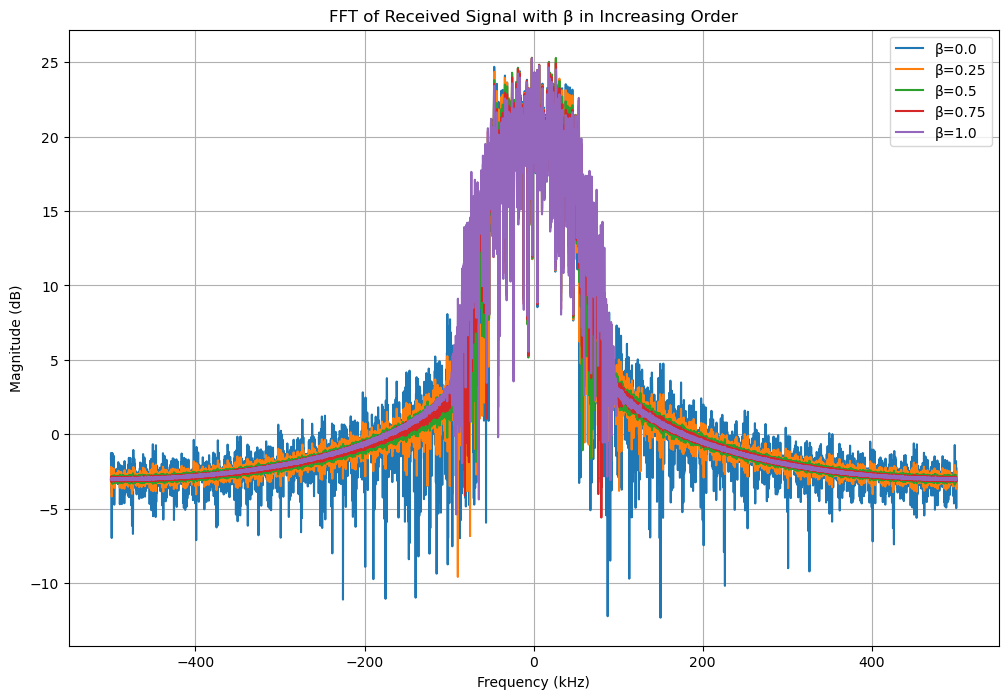

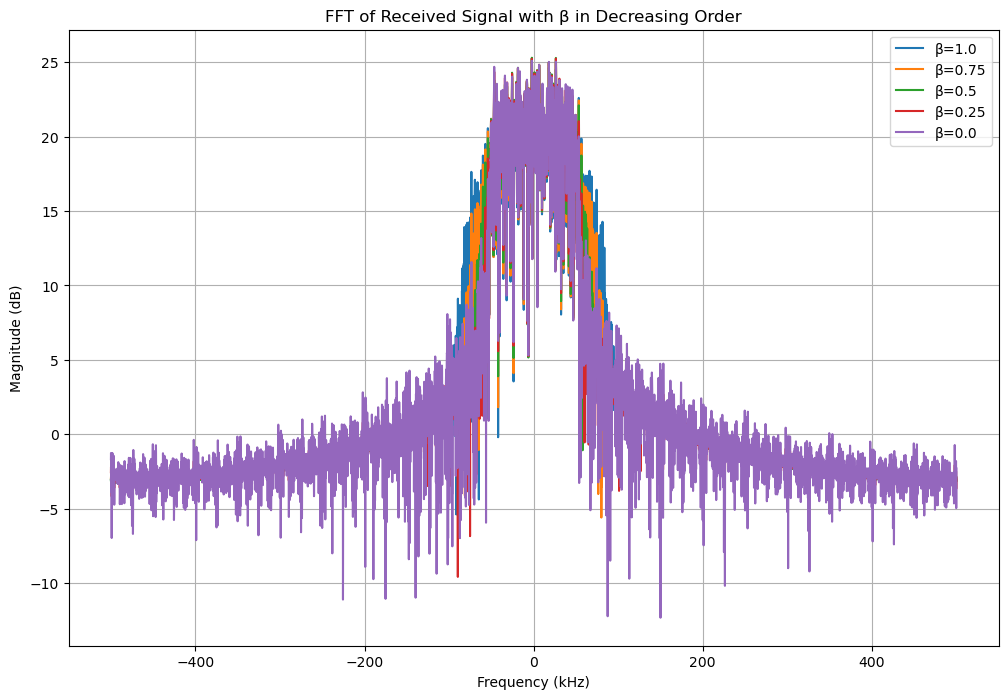

In [10]:
# Plot the FFT of the received signal
sample_rate = 1e6
plt.figure(figsize=(12, 8))
for idx in range(len(beta_list)):
    rx_signal = tx_signal_arr[idx]
    N_fft = len(rx_signal) * 10
    f = np.linspace(sample_rate/-2, sample_rate/2, N_fft)
    rx_fft = np.abs(np.fft.fftshift(np.fft.fft(rx_signal, N_fft)))
    plt.plot(f/1e3, 10*np.log10(rx_fft), label=f'β={beta_list[idx]}')
plt.title("FFT of Received Signal with β in Increasing Order")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.legend()

plt.figure(figsize=(12, 8))
for idx in range(len(beta_list)):
    rx_signal = tx_signal_arr[len(beta_list)-idx-1]
    N_fft = len(rx_signal) * 10
    f = np.linspace(sample_rate/-2, sample_rate/2, N_fft)
    rx_fft = np.abs(np.fft.fftshift(np.fft.fft(rx_signal, N_fft)))
    plt.plot(f/1e3, 10*np.log10(rx_fft), label=f'β={beta_list[len(beta_list)-idx-1]}')
plt.title("FFT of Received Signal with β in Decreasing Order")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.legend()


From these FFTs, we see that increasing rolloff factors decrease the energy in the tail ends of the spectrum at the cost of increased bandwidth around the signal's central frequencies. This makes sense, as a rolloff factor of 0 corresponds to a sinc pulse, and we concluded in HW3 that a sinc pulse has more spectral leakage than a raised-cosine pulse. 

## Appendix


In [11]:
# contents of ece230b.py
# ---------------------------------------------------------------
# ece230b.py
# useful functions for ECE 230B (Digital Communications) with Prof. Ian Roberts, Spring 2025
import numpy as np
import math
import matplotlib.pyplot as plt

def gen_rand_qam_symbols (N, M=4):
    """
    Generate N random symbols from a square M-QAM constellation normalized to unit average symbol energy.
    
    Inputs:
        N: Number of symbols to generate.
        M: Order of QAM constellation. Default is 4 (QPSK).
    
    Outputs:
        symbols: N randomly selected M-QAM symbols.
        constellation: The full M-QAM constellation. 
    """

    if M <= 0 or (M**0.5) % 2 != 0:
        raise ValueError("M must be a positive power of 2.")
    
    # Calculate bits per symbol (bps)
    bps = int(math.log2(M))

    # Generate the M-QAM constellation
    constellation = []
    m_sqrt = int(M**0.5)
    for idx0 in range(m_sqrt):
        for idx1 in range(m_sqrt):
            constellation.append( (2*idx0-(m_sqrt-1)) + 1j*(2*idx1-(m_sqrt-1)) )

    # Normalize the constellation to unit average symbol energy
    constellation /= np.sqrt(np.mean(np.abs(constellation)**2))

    # Randomly select N symbols from the constellation
    symbols = np.random.choice(constellation, N)

    return symbols, constellation
    
def create_pulse_train (symbols, sps):
    """
    Forms a pulse train from a sequence of symbols by inserting zeros between symbols.
    
    Inputs: 
        symbols: QAM symbols.
        sps: Samples per symbol, i.e., the number of discrete-time samples from one symbol to the next.

    Outputs: 
        t: The time vector (samples) for the pulse train, ranging from 0 to len(symbols)*sps-1.
        pulse_train: A discrete-time signal where each symbol is seperated by (sps-1) zeros.
    """
    # Generate time vector (samples) for the pulse train
    t = np.arange(len(symbols) * sps)

    # Generate pulse train from vector of zeros
    pulse_train = np.zeros(len(symbols) * sps, dtype=complex)
    pulse_train[::sps] = symbols

    return t, pulse_train

def get_rc_pulse (beta, span, sps): 
    """
    Generates a raised cosine pulse shape.

    Inputs: 
        beta: Rolloff factor (between 0 and 1, inclusive).
        span: The integer number of symbol durations spanned by the pulse, not including the symbol at t=0. 
        sps: Samples per symbol. 

    Output: 
        t: The time vector (samples) for the pulse, ranging from -span/2 to span/2.
        pulse: A raised cosine pulse (normalized to unit peak), symmetric and centered at t=0. The number of zero crossings should be equal to span. 
    """

    if beta < 0 or beta > 1: 
        raise ValueError("Rolloff factor (beta) must be between 0 and 1.")
    if span < 1:
        raise ValueError("Span must be a positive integer.")
    if sps < 1:
        raise ValueError("Samples per symbol (sps) must be a positive integer.")
    
    # Generate time vector (samples) assuming span is single-sided
    # length = 2*span * sps + 1
    length = span*sps + 1
    t = np.linspace(-span/2, span/2, length)

    # Calculate raised cosine pulse
    if (int(beta) == 0):
        pulse = np.sinc(t)
    else:
        pulse = np.sinc(t) * ( np.cos(np.pi * beta * t) / (1 - ((2 * beta * t)**2)) )
        pulse[np.abs(2 * beta * t) == 1] = (np.pi / 4) * np.sinc(1 / (2 * beta))

    # Normalize to unit peak
    pulse /= np.max(np.abs(pulse))

    # plt.plot(t, pulse)
    # plt.grid(True)
    # plt.show()

    return t, pulse